In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm

In [2]:
df = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')

titanic = df.copy()

In [3]:
titanic.isnull().sum()

passengerId      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [4]:
test_data.isnull().sum()

passengerId      0
pclass           0
name             0
sex              0
age             86
sibsp            0
parch            0
ticket           0
fare             1
cabin          327
embarked         0
dtype: int64

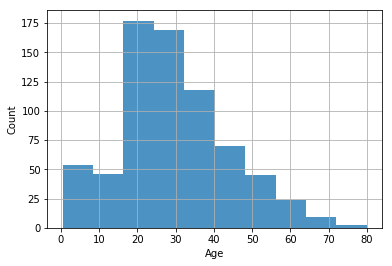

In [5]:
ax = titanic["age"].hist(alpha=0.8)
ax.set(xlabel='Age', ylabel='Count')
plt.show()

In [6]:
titanic.groupby('pclass').mean()

,passengerId,survived,age,sibsp,parch,fare
pclass,,,,,,
1,461.597222,0.629630,38.233441,0.416667,0.356481,84.154687
2,445.956522,0.472826,29.877630,0.402174,0.380435,20.662183
3,439.154786,0.242363,25.140620,0.615071,0.393075,13.675550


In [7]:
titanic.groupby('pclass').median()

,passengerId,survived,age,sibsp,parch,fare
pclass,,,,,,
1,472.0,1.0,37.0,0.0,0.0,60.2875
2,435.5,0.0,29.0,0.0,0.0,14.2500
3,432.0,0.0,24.0,0.0,0.0,8.0500


In [8]:
#reemplazamos los valores faltantes por la mediana de la clase
titanic['age'] = titanic.groupby(['pclass'])['age'].transform(lambda x: x.fillna(x.median()))
test_data['age'] = test_data.groupby(['pclass'])['age'].transform(lambda x: x.fillna(x.median()))

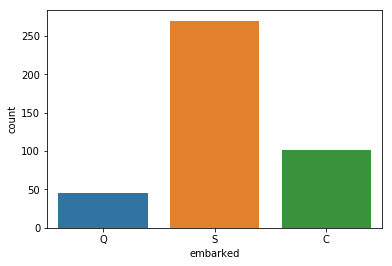

In [9]:
sns.countplot(x = 'embarked', data = test_data)
plt.show()

In [10]:
# Reemplazamos los nulos de 'Embarked' por el puerto más popular
titanic['embarked'].fillna('S', inplace = True)

In [11]:
#Nueva columna para combinar no. padres/hijos y no. hermanos/esposas
titanic['companion'] = [1 if p + s > 0 else 0 for p,s in zip(titanic['parch'], titanic['sibsp'])]
test_data['companion'] = [1 if p + s > 0 else 0 for p,s in zip(test_data['parch'], test_data['sibsp'])]

In [12]:
#Quitamos las columnas que no sirven para el análisis
titanic.drop(columns = ['cabin', 'name','ticket', 'parch', 'sibsp', 'passengerId', 'fare'], inplace = True)
test_data.drop(columns = ['cabin', 'name','ticket', 'parch', 'sibsp', 'passengerId', 'fare'], inplace = True)


In [13]:
titanic.head()

,survived,pclass,sex,age,embarked,companion
0,0,3,male,22.0,S,1
1,1,1,female,38.0,C,1
2,1,3,female,26.0,S,0
3,1,1,female,35.0,S,1
4,0,3,male,35.0,S,0


In [14]:
#Creamos variables dummies para variables categóricas
#Grupo control = (mujer, 1º clase, puerto Q, niño, sin acompañantes)
titanic = pd.get_dummies(titanic, columns = ['pclass', 'sex'], prefix = ['class', 'is'], drop_first = True)
titanic = pd.get_dummies(titanic, columns = ['embarked'], prefix = 'port')
titanic["is_adult"] = np.where(titanic["age"] > 18, 1, 0)
titanic.drop(columns = ['age'], inplace = True)

test_data = pd.get_dummies(test_data, columns = ['pclass', 'sex'], prefix = ['class', 'is'], drop_first = True)
test_data = pd.get_dummies(test_data, columns = ['embarked'], prefix = ['port'])
test_data["is_adult"] = np.where(test_data["age"] > 18, 1, 0)
test_data.drop(columns = ['age'], inplace = True)


In [15]:
titanic2 = titanic.copy()
test_2 = test_data.copy()

In [16]:
titanic = titanic2.copy()
test_data = test_2.copy()

In [17]:
titanic.drop(columns = 'port_Q', inplace = True)
test_data.drop(columns = 'port_Q', inplace = True)

In [18]:
titanic.head()

,survived,companion,class_2,class_3,is_male,port_C,port_S,is_adult
0,0,1,0,1,1,0,1,1
1,1,1,0,0,0,1,0,1
2,1,0,0,1,0,0,1,1
3,1,1,0,0,0,0,1,1
4,0,0,0,1,1,0,1,1


#### Logit

In [19]:
train, test = train_test_split(titanic, test_size = 0.35, random_state = 158999)

In [20]:
y = train['survived']
X = train.drop(columns = ['survived'])

y_test = test['survived']
X_test = test.drop(columns = ['survived'])

In [21]:
logit = sm.Logit(y,X)
logit_model = logit.fit()

Optimization terminated successfully.
         Current function value: 0.466885
         Iterations 6


In [22]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  579
Model:                          Logit   Df Residuals:                      572
Method:                           MLE   Df Model:                            6
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                  0.3036
Time:                        11:40:01   Log-Likelihood:                -270.33
converged:                       True   LL-Null:                       -388.17
                                        LLR p-value:                 4.690e-48
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
companion      0.3383      0.227      1.488      0.137      -0.107       0.784
class_2        0.1507      0.296      0.508      0.611      -0.430       0.731
class_3       -1.1229      0.234     -4.806      0.000      -1.581      -0.665
is_male       -2.4019      0.238    -10.088      0.000      -2.869      -1.935
port_C         1.7514      0.375      4.668      0.000       1.016       2.487
port_S         0.9302      0.330      2.820      0.005       0.284       1.577
is_adult       0.3624      0.255      1.421      0.155      -0.137       0.862
==============================================================================
"""

In [23]:
logreg = LogisticRegression()
logreg.fit(X, y)
y_pred = logreg.predict(X_test)

In [24]:
logreg.score(X_test, y_test)

0.7788461538461539

In [25]:
confusion_matrix(y_test, y_pred)

array([[168,  30],
       [ 39,  75]], dtype=int64)

In [27]:
#Quitamos columnas cuyo p-value sea < 0.05

X2 = train.drop(columns = ['survived'])
X2_test = test.drop(columns = ['survived'])

In [28]:
logit_v2 = sm.Logit(y,X2)
logit_model_v2 = logit_v2.fit()

Optimization terminated successfully.
         Current function value: 0.466885
         Iterations 6


In [29]:
logit_model_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  579
Model:                          Logit   Df Residuals:                      572
Method:                           MLE   Df Model:                            6
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                  0.3036
Time:                        11:42:24   Log-Likelihood:                -270.33
converged:                       True   LL-Null:                       -388.17
                                        LLR p-value:                 4.690e-48
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
companion      0.3383      0.227      1.488      0.137      -0.107       0.784
class_2        0.1507      0.296      0.508      0.611      -0.430       0.731
class_3       -1.1229      0.234     -4.806      0.000      -1.581      -0.665
is_male       -2.4019      0.238    -10.088      0.000      -2.869      -1.935
port_C         1.7514      0.375      4.668      0.000       1.016       2.487
port_S         0.9302      0.330      2.820      0.005       0.284       1.577
is_adult       0.3624      0.255      1.421      0.155      -0.137       0.862
==============================================================================
"""

In [30]:
logreg_v2 = LogisticRegression()
logreg_v2.fit(X2, y)
y2_pred = logreg_v2.predict(X2_test)

In [31]:
logreg_v2.score(X2_test, y_test)

0.7788461538461539

In [32]:
confusion_matrix(y_test, y2_pred)

array([[168,  30],
       [ 39,  75]], dtype=int64)

In [34]:
# Un modelo con solo is male, is adult y class
X3 = train.drop(columns = ['survived', 'companion', 'port_C', 'port_S'])
X3_test = test.drop(columns = ['survived', 'companion', 'port_C', 'port_S'])
logit_v3 = sm.Logit(y,X3)
logit_model_v3 = logit_v3.fit()
logit_model_v3.summary()

Optimization terminated successfully.
         Current function value: 0.503140
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  579
Model:                          Logit   Df Residuals:                      575
Method:                           MLE   Df Model:                            3
Date:                Mon, 08 Apr 2019   Pseudo R-squ.:                  0.2495
Time:                        11:52:52   Log-Likelihood:                -291.32
converged:                       True   LL-Null:                       -388.17
                                        LLR p-value:                 9.697e-42
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
class_2        0.5384      0.253      2.128      0.033       0.042       1.034
class_3       -0.7965      0.207     -3.849      0.000      -1.202      -0.391
is_male       -2.1712      0.213    -10.194      0.000      -2.589      -1.754
is_adult       1.1121      0.206      5.389      0.000       0.708       1.517
==============================================================================
"""

In [35]:
logreg_v3 = LogisticRegression()
logreg_v3.fit(X3, y)
y3_pred = logreg_v3.predict(X3_test)

In [40]:
logreg_v3.score(X3_test, y_test)

0.7756410256410257

In [41]:
confusion_matrix(y_test, y3_pred)

array([[167,  31],
       [ 39,  75]], dtype=int64)

In [48]:
X3.head()

,class_2,class_3,is_male,is_adult
71,0,1,0,0
845,0,1,1,1
716,0,0,0,1
691,0,1,0,0
613,0,1,1,1


In [43]:
logreg_v3.coef_

array([[-0.40968169, -1.80860581, -2.48801978, -0.41576077]])

In [45]:
logreg_v3.intercept_

array([2.41759072])

In [47]:
logreg_v3.decision_function([[0,0,0,0]])

array([2.41759072])

In [56]:
# Grupos de valores de varibles
grupos = [[0,0,0,0], [1,0,0,0], [0,1,0,0],
          [0,0,0,1], [1,0,0,1], [0,1,0,1],
          [0,0,1,0], [1,0,1,0], [0,1,1,0],
          [0,0,1,1], [1,0,1,1], [0,1,1,1]]

# Probabilidad de los grupos en logit 3
probs = np.exp(logreg_v3.decision_function(grupos))/(1+np.exp(logreg_v3.decision_function(grupos)))
probs

array([0.91815889, 0.88162498, 0.64770921, 0.88098908, 0.83091813,
       0.5481563 , 0.48240001, 0.38222597, 0.13249977, 0.38079156,
       0.28989964, 0.0915549 ])

|Sexo|Adulto|Clase 1|Clase 2|Clase 3|
|----|----|----:|----:|----:|
|Mujer|Niño|0.9181588|0.8816249|0.6477092|
|Mujer|Adulto|0.8809890|0.8309181|0.5481563|
|Hombre|Niño|0.4824000|0.3822259|0.1324997|
|Hombre|Adulto|0.3807915|0.2898996|0.0915549|